In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import math
from google.colab import files

uploaded = files.upload()

Saving LoanStats3c.csv to LoanStats3c.csv


In [0]:
#Read the data
df = pd.read_csv('LoanStats3c.csv')
df = df.drop(columns=['url'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Overview

In [0]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,29003494,31526675,28000,28000,28000,36 months,7.12%,866.10,A,A3,attorney,5 years,MORTGAGE,324388.0,Verified,Sep-14,Current,n,NaN,home_improvement,Home improvement,331xx,FL,9.35,0,Aug-01,1,NaN,NaN,23,0,35236,38.70%,34,w,27300.03,27300.03,866.10,866.10,699.97,166.13,0.0,0.0,0.0,Nov-14,866.10,Nov-14,Oct-14,0,NaN,1
1,28913233,31436395,3000,3000,3000,36 months,11.67%,99.18,B,B4,Eligibility Worker II,6 years,MORTGAGE,41500.0,Not Verified,Sep-14,Current,n,NaN,other,Other,961xx,CA,26.55,0,Sep-99,1,NaN,NaN,12,0,11749,78.90%,29,w,2930.00,2930.00,99.18,99.18,70.00,29.18,0.0,0.0,0.0,Oct-14,99.18,Nov-14,Oct-14,0,NaN,1
2,27592013,30095159,18000,18000,18000,36 months,13.98%,615.03,C,C3,LABORATORY MANAGER,8 years,MORTGAGE,165000.0,Verified,Sep-14,Current,n,NaN,debt_consolidation,Debt consolidation,937xx,CA,27.36,0,Apr-89,0,27.0,NaN,15,0,15893,60%,50,f,17594.67,17594.67,615.03,615.03,405.33,209.70,0.0,0.0,0.0,Nov-14,615.03,Nov-14,Oct-14,0,27.0,1
3,28172444,30685592,15000,15000,15000,60 months,20.20%,399.08,E,E3,Housing Counselor,1 year,RENT,67000.0,Source Verified,Sep-14,Current,n,NaN,debt_consolidation,Debt consolidation,946xx,CA,8.90,0,Sep-86,1,70.0,65.0,11,1,1997,24.40%,58,f,14853.42,14853.42,399.08,399.08,146.58,252.50,0.0,0.0,0.0,Nov-14,399.08,Nov-14,Oct-14,0,70.0,1
4,20349337,22622030,23275,23275,23275,60 months,17.57%,585.61,D,D4,Process Improvement Officer,7 years,MORTGAGE,54264.0,Not Verified,Sep-14,Current,n,NaN,debt_consolidation,Debt consolidation,352xx,AL,33.02,0,Aug-02,0,57.0,NaN,11,0,18580,59.60%,23,w,23018.82,23018.82,585.61,585.61,256.18,329.43,0.0,0.0,0.0,Nov-14,585.61,Dec-14,Oct-14,0,57.0,1


In [0]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
count,1.612310e+05,1.612310e+05,161231.000000,161231.000000,161231.000000,161231.000000,1.612310e+05,161231.000000,161231.000000,161231.000000,81008.000000,28929.000000,161231.000000,161231.000000,1.612310e+05,161231.00000,161231.000000,161231.000000,161231.000000,161231.000000,161231.000000,161231.000000,161231.000000,161231.000000,161231.000000,161231.000000,161231.000000,45175.000000,161231.0
mean,1.707150e+07,1.909621e+07,14864.642190,14864.642190,14858.829723,446.003881,7.525850e+04,17.685653,0.341609,0.833078,33.436759,71.541706,11.632620,0.224324,1.603433e+04,26.09554,12866.628505,12861.717114,2804.559524,2803.318488,1963.716128,840.749180,0.033618,0.060596,0.000606,974.164228,0.014191,43.363475,1.0
std,5.098057e+06,5.402435e+06,8412.637516,8412.637516,8409.342582,245.922837,5.740734e+04,7.733079,0.891854,1.094065,21.866078,28.736096,5.175382,0.608610,1.937634e+04,11.73985,8164.581264,8161.674996,3541.682185,3540.075647,3293.447356,777.945894,1.034395,12.659022,0.126590,2996.476958,0.135941,22.153984,0.0
min,5.716700e+04,1.372250e+05,1000.000000,1000.000000,950.000000,23.360000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.263675e+07,1.455757e+07,8400.000000,8400.000000,8400.000000,267.790000,4.600000e+04,11.890000,0.000000,0.000000,15.000000,50.000000,8.000000,0.000000,6.323000e+03,18.00000,6721.390000,6719.815000,1014.270000,1013.825000,609.860000,304.595000,0.000000,0.000000,0.000000,274.695000,0.000000,26.000000,1.0
50%,1.628156e+07,1.828417e+07,13000.000000,13000.000000,13000.000000,387.240000,6.500000e+04,17.360000,0.000000,0.000000,30.000000,70.000000,11.000000,0.000000,1.160700e+04,24.00000,11416.080000,11416.080000,1871.760000,1871.650000,1120.740000,596.540000,0.000000,0.000000,0.000000,402.570000,0.000000,43.000000,1.0
75%,2.101974e+07,2.329278e+07,20000.000000,20000.000000,20000.000000,585.390000,9.000000e+04,23.320000,0.000000,1.000000,49.000000,100.000000,14.000000,0.000000,2.020950e+04,33.00000,17884.720000,17876.160000,3272.010000,3271.485000,1996.775000,1111.970000,0.000000,0.000000,0.000000,623.880000,0.000000,60.000000,1.0
max,2.900349e+07,3.152668e+07,35000.000000,35000.000000,35000.000000,1409.990000,7.500000e+06,39.990000,22.000000,6.000000,188.000000,121.000000,76.000000,63.000000,1.190046e+06,121.00000,35000.000000,35000.000000,40380.500000,40380.500000,35000.000000,6602.910000,100.380000,4278.150000,42.781500,35757.360000,20.000000,188.000000,1.0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161231 entries, 0 to 161230
Data columns (total 51 columns):
id                             161231 non-null int64
member_id                      161231 non-null int64
loan_amnt                      161231 non-null int64
funded_amnt                    161231 non-null int64
funded_amnt_inv                161231 non-null int64
term                           161231 non-null object
int_rate                       161231 non-null object
installment                    161231 non-null float64
grade                          161231 non-null object
sub_grade                      161231 non-null object
emp_title                      152048 non-null object
emp_length                     153250 non-null object
home_ownership                 161231 non-null object
annual_inc                     161231 non-null float64
is_inc_v                       161231 non-null object
issue_d                        161231 non-null object
loan_status                 

# Data Exploration

Let's see all the loans status and their quantity:

In [0]:
df.groupby('loan_status').count()['id']

loan_status
Charged Off              400
Current               151208
Default                   76
Fully Paid              6922
In Grace Period          853
Issued                     1
Late (16-30 days)        409
Late (31-120 days)      1362
Name: id, dtype: int64

Like we can see we only have 76 instances of 'Default' loans. This is very few, and these instances are important. What I would do is use something like **xgboost** to try to solve this

Adding 'debt burden' column, calculated by the monthly payment of the requested loan + other monthly debt payments divided by monthly income:

In [0]:
debt_burden = (df['installment'] / (df['annual_inc'] / 12)) + (df['dti']/100.0)
df['debt_burden'] = debt_burden

Let's get some insigts from the debt burden information of the borrowers:

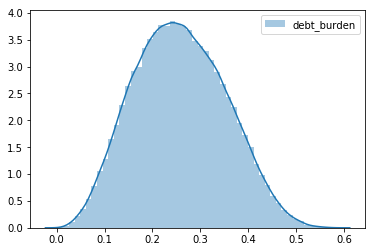

mean: 0.2573251121904496
median: 0.2540416
max: 0.5862
std: 0.0952207475547505
90 percentile: 0.385544
10 percentile: 0.13380263736263737
Number of people with 40% or more debt payment from income: 12087


In [0]:
# Plotting the distribution of loan amount taken
sns.distplot(debt_burden)
plt.legend(['debt_burden'])
plt.show()
print("mean:", debt_burden.mean())
print("median:", debt_burden.median())
print("max:", max(debt_burden))
print("std:", debt_burden.std())

# Getting the outliers
debt_burden_arr = np.array(debt_burden)
print("90 percentile:", np.percentile(debt_burden_arr, 90))
print("10 percentile:", np.percentile(debt_burden_arr, 10))

# How many people with more that 40% burden?
print("Number of people with 40% or more debt payment from income:", len(df[debt_burden >= 0.4]))

We see somthing very close to a normal distribution around 0.25 level of debt payment to income

**Now let's compare the debt burden of the good loans to the bad loans:**

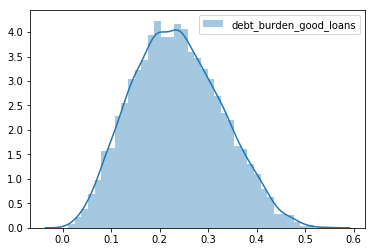

mean: 0.23573721362187594
skew: 0.2148416874725997


In [0]:
df_good_loans = df[df['loan_status'] == 'Fully Paid']

sns.distplot(np.array(df_good_loans['debt_burden']))
plt.legend(['debt_burden_good_loans'])
plt.show()

print("mean:", df_good_loans['debt_burden'].mean())
print("skew:", df_good_loans['debt_burden'].skew())

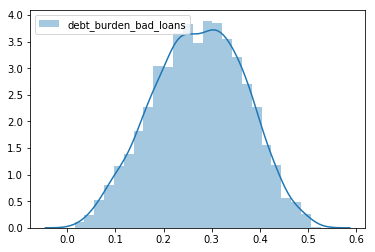

mean: 0.27312447725022293
skew: -0.08930977669025938


In [0]:
df['debt_burden'] = debt_burden_arr
df_bad_loans = df[(df['loan_status'] == 'Default') | (df['loan_status'] == 
                                                      'Late (16-30 days)') | 
                  (df['loan_status'] == 'Late (31-120 days)') |
                 ((df['loan_status'] == 'Charged Off'))]

sns.distplot(np.array(df_bad_loans['debt_burden']))
plt.legend(['debt_burden_bad_loans'])
plt.show()

print("mean:", df_bad_loans['debt_burden'].mean())
print("skew:", df_bad_loans['debt_burden'].skew())

We can see how the distribution of debt burden among bad loans has negative skew where the good lans has a positive skew, and also the average debt burden for the good loans is greater

**Let's check what are the purposes of the loans for the good and the bad one after we classify the purpose of the loan feature for four categories:**

---



In [0]:
df['title'] = [s.lower() for s in df['title']]

In [0]:
df['title'].value_counts()[:10]

debt consolidation         94932
credit card refinancing    37557
home improvement            9217
other                       6717
major purchase              2625
medical expenses            1615
business                    1577
car financing               1238
moving and relocation        872
vacation                     829
Name: title, dtype: int64

In [0]:
# Map items strings to groups according to our logic: each title that contains
# 'debt', 'credit' or 'consolidation' goes to 'DEBT' group. 
# Each title that contains 'home' or related to home goes to 'HOME' group. 
# Another group for cars and another for all the rest:

def title_mapper(title):
  if 'home' in title or 'house' in title or 'lawn' in title or 'heat' in title:
      return 'home'
  elif 'debt' in title or 'consolid' in title or 'consulid' in title or 'credit' in title or 'cc' in title:
    return 'repay_debt'
  elif 'car' in title or 'truck' in title or 'vehicle' in title:
    return 'car'
  else:
    return 'else'

**Note about this mapper:** this is a primitive mapper, we can do advanced work on it, as I will explain later

In [0]:
df['title'] = list(map(title_mapper, df['title']))

repay_debt    134442
else           15597
home            9863
car             1329
Name: title, dtype: int64


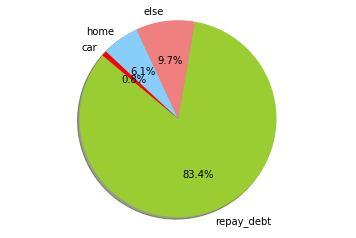

In [0]:
title_val_count = df['title'].value_counts()
print(title_val_count)

# Data to plot
labels = 'repay_debt', 'else', 'home', 'car'
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'red']

# Plot
plt.pie(title_val_count, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Like we can see, repay debt purpose is the majority among loan purposes

**Number of inquieries by creditors in the last six months:**

In [0]:
df['inq_last_6mths'].value_counts()

0    81745
1    45381
2    20489
3     8654
4     3278
5     1219
6      465
Name: inq_last_6mths, dtype: int64

Let's look at the porportion of bad loans (default + late) group by the number of inquiries by creditors during the last 6 months ('inq_last_6mths'):

0    0.208899
1    0.220258
2    0.248756
3    0.267717
4    0.230241
5    0.218487
6    0.322581
Name: inq_last_6mths, dtype: float64


Number of inquiries(x) and the proportion of the bad loans(y)


[]

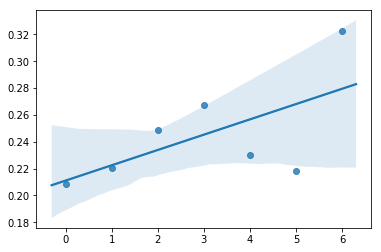

In [0]:
df_bad_loans = df[(df['loan_status'] == 'Default') | (df['loan_status'] == 'Late (16-30 days)') | (df['loan_status'] == 'Late (31-120 days)') |
                 (df['loan_status'] == 'Charged Off')]
prop_bad_inq = df_bad_loans['inq_last_6mths'].value_counts() /df[df['loan_status'] != 'Current']['inq_last_6mths'].value_counts()
print(prop_bad_inq)
print()
print()
print("Number of inquiries(x) and the proportion of the bad loans(y)")
fig = plt.figure()
ax = sns.regplot(x=np.array(prop_bad_inq.keys()), y=np.array(prop_bad_inq.values))
ax.plot()

In this graph we can see the positive connection between the number of inquiries by creditors and the proportion of the bad loans out of all finished loans

Also we'll present the ratio of the fully paid borrowers out of the total **for each grade**: (without currents)



In [0]:
# Filter only to Fully Paid status and then group by grade and count
fully_paid = df[df['loan_status'] == 'Fully Paid']
fully_paid_by_grade = fully_paid.groupby('grade').count()

# Let's count the total (anything but current loans) for each grade and count
df_no_curr = df[df['loan_status'] != 'Current']
df_no_curr_by_grade = df_no_curr.groupby('grade').count()

# Get the ratio of count of each status when fully paid and count of each status total except current 
fully_paid_by_grade['ratio'] = fully_paid_by_grade['id'] / df_no_curr_by_grade['id']

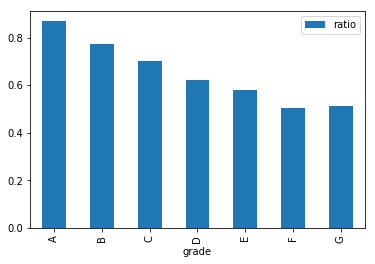

In [0]:
fully_paid_by_grade.plot.bar(y='ratio')

What's interesting that G rating has better 'success rate' than F, when G pays greater interest rates, but we need to take into account that we have very few observations for those statuses

# Feature Modification

---

In [0]:
# Since I see that the revolving util only has very small proportion of null 
# values I will fill the missing values with the average of the rest 

def rev_to_float(s):
    try:
      return float(s.replace('%', ''))/100.0
    except AttributeError:
      return np.nan
df['revol_util'] = [rev_to_float(s) for s in df['revol_util']]
rev_util_mean = df['revol_util'].mean()
df['revol_util'] = df['revol_util'].fillna(rev_util_mean)

Casting features that need to be numbers and not strings:

In [0]:
# Removing all non-numeric chars and cast to float
def str_to_float(s):
    if not isinstance(s, str):
      return np.nan
    return float(re.sub("[^0-9.]", "", s))  
df['int_rate'] = df['int_rate'].apply(str_to_float) 

# Changing the zip code to be an int (first 3 numbers)
def zip_to_int(s):
    return int(s[:3])
df['zip_code'] = [zip_to_int(s) for s in df['zip_code']]

# Casting employment length to float
df['emp_length'] = df['emp_length'].apply(str_to_float)
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].mean())

In [0]:
df_no_curr = df[df['loan_status'] != 'Current']

**Note about leaving only non-current:** The fact that I filter so many observations is highly problematic, But I want only the tagged data (in terms of loan status). There are probably ways to use these current observations, maybe as semi-tagged derived from clues in the data. Another thing that we can do with these observations is to use unsupervised models, such as anomaly detection or such. But for this work we will use only the non-current ones

In [0]:
len(df_no_curr['emp_title'].unique())

5533

In [0]:
num_of_nulls_per_col = df_no_curr.isnull().sum(axis = 0)
num_of_nulls_per_col = num_of_nulls_per_col[num_of_nulls_per_col != 0]  # Filtering the zeros from this series
num_of_nulls_per_col

emp_title                       527
desc                           8462
mths_since_last_delinq         5032
mths_since_last_record         8235
last_pymnt_d                    107
next_pymnt_d                   7322
last_credit_pull_d                1
mths_since_last_major_derog    7191
dtype: int64

Like we can see there are columns which most of their values are missing, let's take them out 

In [0]:
df_no_curr = df_no_curr.drop(columns=['next_pymnt_d', 'mths_since_last_major_derog', 'desc', 'mths_since_last_record', 'mths_since_last_delinq'])

I thought about fillng the emp length by average according to the grade but I see they're close to each other so no need

In [0]:
num_of_nulls_per_col = df_no_curr.isnull().sum(axis = 0)
num_of_nulls_per_col = num_of_nulls_per_col[num_of_nulls_per_col != 0]  # Filtering the zeros from this series
num_of_nulls_per_col

emp_title             527
last_pymnt_d          107
last_credit_pull_d      1
dtype: int64

I will drop the rows that have nan values sinse they're only 107-108 of them, and I will not going to work with emp title for now so I will drop it

In [0]:
df_no_curr = df_no_curr.dropna()

In [0]:
print("We have left with:", len(df_no_curr), "instances")
num_of_nulls_per_col = df_no_curr.isnull().sum(axis = 0)
num_of_nulls_per_col = num_of_nulls_per_col[num_of_nulls_per_col != 0]  # Filtering the zeros from this series
num_of_nulls_per_col  # Should return an empty series

We have left with: 9393 instances


Series([], dtype: int64)

# **Dealing with categories**

---

# The Problem Of 'emplyment title':

**The problem:**
Emplyment title is an important feature that tells alout about a borrower quality. The problem is that this field was filled in free language, which caused for thousands of unique strings trying to specify people's occupations. 

**Solution:** 
First of all I would use some NLP techniques: remove stop words, change everything to lower case and try to reduce words by find synonyms or words with the same meaning and turn them to one word ('car' and 'vehicle' will be one word). 
Then, I will want to cluster the occupation. There are several metods for clutering text, such as td-idf or LDA. I wouldn't choose td-idf since this algorithm takes into account the freq of a word in the instance divided by the frequency of this words in all instances, and in the 'emp title' we deal with very few words in each instance, hence title. I would try to use LDA, and then cluster each title to its "topic". Then I would have less unique values so I could encode it better, and the prediction models would probably work better

For now I will drop it:

In [0]:
df_no_curr = df_no_curr.drop(columns=['emp_title'])

**Some of the categories are ordinal (order is important or there's meaning to the value) and some are nominal (all category ae equaly important) which I'll use dummies (one hot encoding):**



In [0]:
# Where magnitude/order is important
df_no_curr['term'] = df_no_curr['term'].astype('category').cat.codes  
df_no_curr['grade'] = df_no_curr['grade'].astype('category').cat.codes 
df_no_curr['sub_grade'] = df_no_curr['sub_grade'].astype('category').cat.codes
df_no_curr['loan_status'] = df_no_curr['loan_status'].astype('category').cat.codes


def str_to_date_to_int(date_str):
    # this the foramt we get for example: Oct-29
    try:
      date = datetime.strptime(date_str, '%b-%d')
    except ValueError:
      return -1     
    return 100*date.month + date.day
  
# Another mapper for date with year, like in earliest_cr_line  
def str_to_date_to_int_year(date_str):
    # this the foramt we get for example: Oct-99
    try:
      date = datetime.strptime(date_str, '%b-%y')
    except ValueError:
      return -1     
    return 100*date.year + date.month
  
df_no_curr['last_credit_pull_d'] = df_no_curr['last_credit_pull_d'].apply(str_to_date_to_int_year)
df_no_curr['last_pymnt_d'] = df_no_curr['last_pymnt_d'].apply(str_to_date_to_int_year)
df_no_curr['issue_d'] = df_no_curr['issue_d'].apply(str_to_date_to_int_year)
df_no_curr['earliest_cr_line'] = df_no_curr['earliest_cr_line'].apply(str_to_date_to_int_year)
#df_no_curr = df_no_curr[df_no_curr['earliest_cr_line'] != -1]  # Taking out all the non-valid values

# All variables are equally important - we use dummy variables
df_feature_ready = pd.get_dummies(df_no_curr, columns=['initial_list_status', 
                                               'pymnt_plan', 'purpose', 
                                               'addr_state', 'home_ownership', 
                                               'is_inc_v', 'title'], 
                           prefix = ['initial_list_status', 'pymnt_plan', 
                                        'purpose', 'addr_state', 
                                        'home_ownership', 'is_inc_v', 'title'])

In [0]:
df_feature_ready.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,issue_d,loan_status,zip_code,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,initial_list_status_f,initial_list_status_w,...,addr_state_MA,addr_state_MD,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,is_inc_v_Not Verified,is_inc_v_Source Verified,is_inc_v_Verified,title_car,title_else,title_home,title_repay_debt
252,27961985,30465098,10000,10000,10000,0,16.99,356.48,3,17,7.0,86000.0,201409,2,20,20.03,1,199410,1,16,1,26855,0.774,55,0.0,0.0,10141.59,10141.59,10000.0,141.59,0.0,0.0,0.0,201410,10141.59,201411,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
631,27522055,30025199,17000,17000,16975,0,6.49,520.96,0,1,1.0,129996.0,201409,2,296,7.07,1,199602,1,8,0,7845,0.139,21,0.0,0.0,17100.91,17075.76,17000.0,100.91,0.0,0.0,0.0,201410,17100.91,201410,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
636,27522110,30025261,8025,8025,8025,0,18.24,291.10,3,19,10.0,68000.0,201409,2,190,6.23,0,199811,1,11,0,9134,0.823,16,0.0,0.0,8146.98,8146.98,8025.0,121.98,0.0,0.0,0.0,201410,8146.98,201411,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
794,27541860,30044989,20000,20000,20000,1,11.67,441.57,1,8,4.0,100000.0,201409,2,217,7.72,1,199509,1,11,0,11481,0.649,34,0.0,0.0,20194.50,20194.50,20000.0,194.50,0.0,0.0,0.0,201410,20194.50,201410,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
829,27601871,30105029,14000,14000,14000,1,20.20,372.48,4,22,5.0,41500.0,201409,2,605,13.98,0,199403,2,11,0,9554,0.415,48,0.0,0.0,14235.67,14235.67,14000.0,235.67,0.0,0.0,0.0,201410,14235.67,201410,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


**Note for the ordinal categorial featurs:** we represent them with integers. But we need to make sure that their values don't hurt the model. For example: 'term' should be 36 and 60, or 0 and 1? or maybe somethig else? we need to examine this. 

# **Modeling**

In [0]:
x=df_feature_ready.drop(['loan_status', 'grade'],axis=1).values  # I take out the grade as well since sub grade is in and they are highly correlated
y=df_feature_ready['loan_status']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=21)

**Random Forest**


Let's try to predict, given a new borrower, in which loan status category is going to end up:

In [0]:
rfc = RandomForestClassifier(max_depth=7)
rfc.fit(x_train, y_train)
rfc_score_train = rfc.score(x_train, y_train)
print("Training score: ",rfc_score_train)
rfc_score_test = rfc.score(x_test, y_test)
print("Testing score: ",rfc_score_test)

Training score:  0.9447908745247148
Testing score:  0.9229950319375444


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Conclusions about the model:**

* I choose random forest because its ability to control overfitting and dealing with high dimensonality. 

* And yet, it looks like there is overfitting (training score is very high). Porbably mainly because there are some labels that very few, like 76 observation for 'Default'. I can solve it by a) getting more data, or b), like I already wrote, using xgboost or something similar to that to give this labels more weight. 

* Another problem is that some of the features are correlated. (grade - sub grade, income and grade etc.). This is obviously need more work and research




# **Lior Katz**